# INF161 Project - Preperation 


# Værdata:
- Dato: Dato for periodens aggregater.
- Tid: Tid er målt hvert tiende minutt.
- Globalstråling: Strålingen som kommer inn mot en horisontalflate kalles globalstråling, og er summen av direkte solstråling og spredt stråling. 
- Solskinstid: Når sola står opp og når den går ned.
- Lufttemperatur: Temperatur.
- Vindretning: Vindretningen angir hvilken retning vinden blåser fra.
- Vindstyrke: Vindstyrke.
- Lufttrykk: Lufttrykket ved bakken er vekten av lufta over oss.


# Trafikk_data:
- Trafikkregistreringspunkt: Punktets unike ID
- Navn: Punktets navn
- Vegreferanse: Punktets plassering på vegnettet.
- Fra: Starttidspunktet for periodens aggregater.
- Til: Sluttidspunktet for periodens aggregater.
- Dato: Dato for periodens aggregater.
- Fra tidspunkt: Starttidspunktet for timen.
- Til tidspunkt: Sluttidspunktet for timen.
- Felt: 
    - Felt: Kjørefeltet som kjøretøyet er registrert i. Angir fysisk plassering i vegbanen.
    - Retning: Den faktiske kjøreretningen til kjøretøyet. I tilfeller der bilen kjører på "feil" side av vegen, 
      blir kjøreretningen angitt som den motsatte av feltets angitte retning.
    - Totalt: angir summen av alle kjørefelt (det samme som summen av begge retninger).
- Volum: Trafikkmengden for den aktuelle perioden. For måned-, sesong- og årsdøgntrafikk er dette gjennomsnittlig trafikkmengde per døgn.
- Dekningsgrad (%): Andel tid det er gode data for i perioden.
- Antall timer total: Antall timer eller døgn i perioden.
- Antall timer inkludert: Antall timer som har data i perioden.
- Antall timer ugyldig: Antall timer i perioden med ukjent kvalitet.
- Ikke gyldig lengde: Antall kjøretøy som er vurdert til å ha underkjent lengdemåling. Disse kjøretøyene inngår ikke i lengdeklassifiseringen.
- Lengdekvalitetsgrad: Andel i prosent av kjøretøy med godkjent lengdemåling.
- < 5,6m etc: Antall kjøretøy målt til å være kortere enn 5,6 m. Grensen 5,6 m brukes som skille på lette og tunge kjøretøy.




# Kommentarer om data:

* Trafikk_data
 - Tid er målt hver time.

* Værdata / Florida_data
 - En del NaN og '-' verdier.
 - Værdata bruker verdien 9999.99 for manglende data.
 - Tid er målt hvert tiende minutt, som er forskjellig fra trafikk_data, der tid blir målt hver time. Løsningen blir å presentere dataen i Værdata for hver time, og ta gjennomsnittet av hver sjette data i kolonnen (fordi 60min/10min=6)
 

# Problemstilling

- Volumet, altså antall personer som sykler i begge retninger (Totalt), for 2022 mangler. Målet er å predikere "Volum" der feltet er "Totalt".

# Kilder

- Dataen fra "Værdata" kommer fra Geofysisk institutt. https://veret.gfi.uib.no/
- Dataen fra "Trafikk_data" kommer fra Statens Vegvesen. https://www.vegvesen.no/trafikkdata/start/om-trafikkdata

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as mp
import datetime as dt
from sklearn.model_selection import train_test_split

from glob import glob



In [2]:
weather_files = sorted(glob('raw_data/Florida*.csv'))

# Værdata

In [3]:
# Leser inn dataen
weather_df = pd.concat(pd.read_csv(datafile).assign(sourcefilename = datafile) for datafile in weather_files)
weather_df.head()

,Dato,Tid,Globalstraling,Solskinstid,Lufttemperatur,Vindretning,Vindstyrke,Lufttrykk,Vindkast,sourcefilename
0,2015-01-01,00:00,18.1,0.0,6.6,166.0,4.2,1008.6,NaN,raw_data/Florida_2015-01-01_2016-01-01_1654174...
1,2015-01-01,00:10,19.5,0.0,6.6,159.0,4.0,1008.6,NaN,raw_data/Florida_2015-01-01_2016-01-01_1654174...
2,2015-01-01,00:20,20.2,0.0,6.6,154.0,3.1,1008.3,NaN,raw_data/Florida_2015-01-01_2016-01-01_1654174...
3,2015-01-01,00:30,20.2,0.0,6.6,154.0,3.7,1008.3,NaN,raw_data/Florida_2015-01-01_2016-01-01_1654174...
4,2015-01-01,00:40,20.2,0.0,6.7,151.0,2.9,1007.9,NaN,raw_data/Florida_2015-01-01_2016-01-01_1654174...


In [4]:
# Sjekker datatypene til variablene.
# Set at samtlige kolonner bortsett fra 'Dato' og 'Tid' er formatert som float64.
# Kan bruke 'Dato' og 'Tid' til å lage en 'dato_tid' indeks.
weather_df.dtypes

Dato               object
Tid                object
Globalstraling    float64
Solskinstid       float64
Lufttemperatur    float64
Vindretning       float64
Vindstyrke        float64
Lufttrykk         float64
Vindkast          float64
sourcefilename     object
dtype: object

In [5]:
# Teller antall missing values blant variablene/kolonnene.
weather_df.isnull().sum()

Dato                 0
Tid                  0
Globalstraling     798
Solskinstid        799
Lufttemperatur     798
Vindretning        797
Vindstyrke         797
Lufttrykk          797
Vindkast          1101
sourcefilename       0
dtype: int64

In [6]:
# Vil erstatte 9999.99, som er oppgitt til å representere nullverdier, med NaN.
weather_df = weather_df.replace(9999.99, np.nan)

In [7]:
weather_df.drop(['Vindretning','Vindkast', 'sourcefilename'], inplace = True, axis = 1)

In [8]:
# Vil indeksere datasettet med et dato og tidspunkt. Kombinerer 'Dato' og 'Tid' variablene.
weather_df.loc[:,'dato_tid'] = pd.to_datetime(weather_df['Dato'] + " " + weather_df['Tid'])
weather_df.drop(['Dato', 'Tid'], inplace = True, axis = 1)
weather_df = weather_df.set_index('dato_tid')

Som sagt er det er problem at tid blir målt hvert tiende minutt i værdata, men hver time i trafikkdata. Løsningen blir å forandre på værdata sitt tidsstempel. For å gjøre dette kan en bruke en metode fra Pandas Dataframe som heter .resample(rule), som tar inn en String som parameter, der Stringen representerer tidsstempelet vi vil ha det målt i.

.resample("60T") vil gjøre sample serien til hvert 60. minutt, altså hver time og ta gjennomsnittet av verdiene
i kolonnene innenfor det tidsintervallet.

In [9]:
weather_df = weather_df.resample('60T').agg({'Solskinstid':'mean',
                                        'Globalstraling' : 'mean',
                                        'Lufttemperatur':'mean',
                                        'Vindstyrke':'mean',
                                        'Lufttrykk' : 'mean'})  

In [10]:
# Det endelige vær-datasettet som vil bli sendt videre til kombinering.
weather_df

,Solskinstid,Globalstraling,Lufttemperatur,Vindstyrke,Lufttrykk
dato_tid,,,,,
2015-01-01 00:00:00,0.0,19.850000,6.633333,3.483333,1008.250000
2015-01-01 01:00:00,0.0,18.916667,6.816667,3.350000,1007.083333
2015-01-01 02:00:00,0.0,21.133333,6.983333,3.783333,1006.016667
2015-01-01 03:00:00,0.0,21.833333,7.200000,4.016667,1005.016667
2015-01-01 04:00:00,0.0,22.883333,7.533333,5.016667,1003.883333
...,...,...,...,...,...
2022-05-28 22:00:00,0.0,-0.483333,7.450000,4.983333,1009.866667
2022-05-28 23:00:00,0.0,-0.766667,7.133333,5.050000,1009.466667
2022-05-29 00:00:00,0.0,-0.816667,7.016667,4.566667,1009.050000


# Trafikkdata

In [11]:
# Leser inn data
traffic_df = pd.read_csv('raw_data/trafikkdata.csv', delimiter = ';', low_memory = False)
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421383 entries, 0 to 421382
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Trafikkregistreringspunkt  421383 non-null  object 
 1   Navn                       421383 non-null  object 
 2   Vegreferanse               421383 non-null  object 
 3   Fra                        421383 non-null  object 
 4   Til                        421383 non-null  object 
 5   Dato                       421383 non-null  object 
 6   Fra tidspunkt              421383 non-null  object 
 7   Til tidspunkt              421383 non-null  object 
 8   Felt                       421383 non-null  object 
 9   Volum                      396200 non-null  object 
 10  Dekningsgrad (%)           421383 non-null  object 
 11  Antall timer total         396200 non-null  float64
 12  Antall timer inkludert     396200 non-null  float64
 13  Antall timer ugyldig       39

    Umiddelbare tiltak i traffic_df:
- Flere av kolonnene står uten verdier: "< 5,6m", ">= 5,6m", "5,6m - 7,6m", "7,6m - 12,5m", "12,5m - 16,0m", ">= 16,0m", "16,0m - 24,0m", ">= 24,0m". Velger å fjerne disse da lengdemåling av sykler ikke er relevant.

- Fjerner også "Ikke gyldig lengde" som beskriver "Antall kjøretøy som er vurdert til å ha underkjent lengdemåling. Disse kjøretøyene inngår ikke i lengdeklassifiseringen." Dette gjelder alle sykler, ikke relevant.

- Gjentakende verdier i "Trafikkregistreringspunkt", "Navn", "Vegreferanse". Fjerner disse siden alle målinger skjer på samme sted. Ikke interessant for min undersøkelse.

- Fjerner 'Til' kolonnen da den er avhengig av 'Fra'. Ser for meg å kunne bruke 'Fra' videre i prosessen.

- Fjerner 'Til tidspunkt' kolonnen da der er avhengig av 'Fra tidspunkt'. Vil bruke 'Fra tidspunkt' videre til å lage 'dato_tid' indeksen med to_datetime.
    
- Vil også filtrere dataen slik at vi bare bruker kolonnen "Felt" der verdien er "Totalt",
  siden vi vil ha for begge retninger. Der det står "Total" vises det totale antallet passeringer.

- Fjerner 'Antall timer total' fordi verdien alltid er 1. Ikke interessant.

- Fjerner 'Antall timer inkludert'fordi verdien alltid er 1. Ikke interessant.

In [12]:
# Gjør Volum kolonnen om til numeriske verdier.
traffic_df['Volum'] = pd.to_numeric(traffic_df['Volum'], errors = 'coerce')

In [13]:
# Vil undersøke dekningsgrad. Må endre på formateringen til numeriske verdier.
traffic_df['Dekningsgrad (%)'] = [x.replace(',', '.') for x in  traffic_df['Dekningsgrad (%)']]
traffic_df['Dekningsgrad (%)'] = pd.to_numeric(traffic_df['Dekningsgrad (%)'], errors='coerce')

In [14]:
# Kolonnene jeg vil ha med videre
traffic_columns = ['Fra','Dato', 'Fra tidspunkt', 'Felt', 'Volum', 'Dekningsgrad (%)', 'Antall timer ugyldig']
traffic_df = traffic_df[traffic_columns].copy()

# Erstatter  '-' i Volum-kolonnen med NaN verdier.
traffic_df['Volum'].replace(['-'],np.nan,inplace=True)

In [15]:
# Ser at verdiene i kolonnen 'Felt' er konsistent.
traffic_df.Felt.value_counts()

1                                    60198
2                                    60198
3                                    60198
4                                    60198
Totalt i retning DANMARKSPLASS       60197
Totalt i retning FLORIDA/ SENTRUM    60197
Totalt                               60197
Name: Felt, dtype: int64

In [16]:
# Filtrerer for "Felt" der verdien er "Totalt"
traffic_df = traffic_df[traffic_df['Felt'].isin(['Totalt'])]
traffic_df

,Fra,Dato,Fra tidspunkt,Felt,Volum,Dekningsgrad (%),Antall timer ugyldig
6,2015-07-16T15:00+02:00,2015-07-16,15:00,Totalt,NaN,0.0,1.0
13,2015-07-16T16:00+02:00,2015-07-16,16:00,Totalt,107.0,100.0,0.0
20,2015-07-16T17:00+02:00,2015-07-16,17:00,Totalt,84.0,100.0,0.0
27,2015-07-16T18:00+02:00,2015-07-16,18:00,Totalt,57.0,100.0,0.0
34,2015-07-16T19:00+02:00,2015-07-16,19:00,Totalt,49.0,100.0,0.0
...,...,...,...,...,...,...,...
421350,2022-05-30T16:00+02:00,2022-05-30,16:00,Totalt,NaN,NaN,NaN
421357,2022-05-30T17:00+02:00,2022-05-30,17:00,Totalt,NaN,NaN,NaN
421364,2022-05-30T18:00+02:00,2022-05-30,18:00,Totalt,NaN,NaN,NaN
421371,2022-05-30T19:00+02:00,2022-05-30,19:00,Totalt,NaN,NaN,NaN


In [17]:
#Ser at kolonnen 'Felt' kun inneholder "Totalt". Kan fjerne denne kolonnen for å få et ryddigere datasett.
traffic_df = traffic_df.drop(columns = 'Felt')

In [18]:
# Benytter pandas sin to_datetime funksjon for å få det på likt format som i værdata.
traffic_df['dato_tid'] = pd.to_datetime(traffic_df.Dato + ' ' + traffic_df['Fra tidspunkt'])

# Fjerner"Fra tidspunkt", "Til tidspunkt".
traffic_df.drop(['Fra tidspunkt'], inplace = True, axis = 1)
traffic_df = traffic_df.set_index('dato_tid')

In [19]:
# Det endelige traffik-datasettet som vil bli sendt videre til kombinering.
traffic_df

,Fra,Dato,Volum,Dekningsgrad (%),Antall timer ugyldig
dato_tid,,,,,
2015-07-16 15:00:00,2015-07-16T15:00+02:00,2015-07-16,NaN,0.0,1.0
2015-07-16 16:00:00,2015-07-16T16:00+02:00,2015-07-16,107.0,100.0,0.0
2015-07-16 17:00:00,2015-07-16T17:00+02:00,2015-07-16,84.0,100.0,0.0
2015-07-16 18:00:00,2015-07-16T18:00+02:00,2015-07-16,57.0,100.0,0.0
2015-07-16 19:00:00,2015-07-16T19:00+02:00,2015-07-16,49.0,100.0,0.0
...,...,...,...,...,...
2022-05-30 16:00:00,2022-05-30T16:00+02:00,2022-05-30,NaN,NaN,NaN
2022-05-30 17:00:00,2022-05-30T17:00+02:00,2022-05-30,NaN,NaN,NaN
2022-05-30 18:00:00,2022-05-30T18:00+02:00,2022-05-30,NaN,NaN,NaN


# Kombinerer værdata og trafikkdata 

In [20]:
merged_df = traffic_df.join(weather_df, how = 'left')

In [21]:
#Gjenoppretter en kolonne med datoene for å kunne bruke apply.
merged_df['Datoer'] = merged_df.index.to_frame(name='Datoer')['Datoer']

# Lager noen flere variabler enn de som allerede er i rådata
merged_df['År'] = merged_df['Datoer'].apply(lambda x: x.year)
merged_df['Måned'] = merged_df['Datoer'].apply(lambda x: x.month)
merged_df['Ukedag'] = merged_df['Datoer'].apply(lambda x: x.isoweekday())
merged_df['Dato'] = merged_df['Datoer'].apply(lambda x: x.day)
merged_df['Klokkeslett'] = merged_df['Datoer'].apply(lambda x: x.hour)

# Vil lage en kolonne dersom det er fellesferie, som er i juli. (På bakgrunn av analyse gjort lenger nede)
merged_df["Fellesferie"] = merged_df['Måned'].apply(lambda x : x == 7)
merged_df['Fellesferie'] = merged_df['Fellesferie'].replace([True, False], [1, 0])

In [22]:
# Vil fjerne verdiene fra 2022 og utover og ta vare på de. 
target_df = merged_df[merged_df['Fra'].str.contains('2022')]

# Fjerner kolonnen Fra
merged_df = merged_df.drop('Fra', axis=1)
target_df = target_df.drop('Fra', axis = 1)

Vil ikke ta med data fra mars 2020 og utover på bakgrunn av den første lockdownen som ble iverksatt 12.mars 2020.
Det kan tenkes at dette vil påvirke modellen da de fleste endte opp med hjemmekontor og kanskje syklet
mer enn normalen for å unngå kollektivtransport. 

In [23]:
start_tid = '2015-07-16'
slutt_tid = '2020-03-11'
merged_df = merged_df.loc[merged_df['Datoer'].between(start_tid, slutt_tid)]

# Kan nå fjerne kolonnen Datoer da den er brukt til det som var hensikten.
merged_df = merged_df.drop('Datoer', axis = 1)
target_df = target_df.drop('Datoer', axis = 1)

In [24]:
# Det endelige datasettet. Vil nedenfor utforske noen av variablene i treningsdataen før
# variablene som sendes videre til preprocessing blir valgt.
merged_df

,Dato,Volum,Dekningsgrad (%),Antall timer ugyldig,Solskinstid,Globalstraling,Lufttemperatur,Vindstyrke,Lufttrykk,År,Måned,Ukedag,Klokkeslett,Fellesferie
dato_tid,,,,,,,,,,,,,,
2015-07-16 15:00:00,16,NaN,0.0,1.0,7.233333,504.400000,13.900000,4.083333,1014.433333,2015,7,4,15,1
2015-07-16 16:00:00,16,107.0,100.0,0.0,8.116667,432.833333,13.733333,4.333333,1014.400000,2015,7,4,16,1
2015-07-16 17:00:00,16,84.0,100.0,0.0,10.000000,378.400000,13.866667,3.933333,1014.066667,2015,7,4,17,1
2015-07-16 18:00:00,16,57.0,100.0,0.0,10.000000,212.583333,13.216667,4.233333,1013.966667,2015,7,4,18,1
2015-07-16 19:00:00,16,49.0,100.0,0.0,10.000000,79.750000,12.683333,2.950000,1014.100000,2015,7,4,19,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-10 20:00:00,10,42.0,100.0,0.0,0.000000,-0.133333,4.550000,2.500000,975.950000,2020,3,2,20,0
2020-03-10 21:00:00,10,20.0,100.0,0.0,0.000000,-0.183333,5.233333,2.116667,976.233333,2020,3,2,21,0
2020-03-10 22:00:00,10,10.0,100.0,0.0,0.000000,0.000000,5.733333,2.450000,976.716667,2020,3,2,22,0


# Utforskende analyse på treningsdataen.


 Train test split:
Train test split er en metode innen valideringen av modellen som lar deg simulere hvordan modellen din ville prestere med nye data/ikke eksisterende data.

Vil altså først splitte opp i trenings og test data fra hele datasettet. Splitter de opp ved å bruke train_split_test funksjonen fra sklearn.model_selection i 70% treningsdata og 15% testdata. 

Videre splitter jeg opp treningsdataen i trening og valideringsdata slik at det totalt blir 70% treningsdata, 15% valideringsdata og 15% testdata.

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
# Lagrer feature matrisen som 'X'
feature_cols = ['År','Måned', 'Dato','Ukedag', 'Klokkeslett', 'Lufttemperatur',
                'Vindstyrke','Lufttrykk', 'Fellesferie','Globalstraling', 'Solskinstid',
                'Dekningsgrad (%)', 'Antall timer ugyldig' ]

X = merged_df[feature_cols].copy()

# Lagrer responsvektoren som 'y'
y = merged_df['Volum'].copy()


# Splitter slik at det først blir 70% treningsdata og 30% testdata
X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.3, shuffle = False)
    
#For at det skal bli 15% valideringsdata splittes testdataen opp i 50/50
X_test, X_val, y_test, y_val = train_test_split(X_test1, y_test1, test_size=0.5, shuffle = False)

In [27]:
# Ser at når 'Antall timer ugyldig' er 1, så er også 'Dekningsgrad (%)' lik 0.0.
# 'Antall timer ugyldig' er derfor ikke nyttig
X_train.loc[(X_train['Dekningsgrad (%)'] == 0.0) & (X_train['Antall timer ugyldig'] == 1)]

# Kan droppe 'Antall timer ugyldig'
X_train.drop(['Antall timer ugyldig'], inplace = True, axis = 1)

In [28]:
X_train.isnull().sum()

År                   0
Måned                0
Dato                 0
Ukedag               0
Klokkeslett          0
Lufttemperatur      61
Vindstyrke          61
Lufttrykk           61
Fellesferie          0
Globalstraling      53
Solskinstid         69
Dekningsgrad (%)     0
dtype: int64

In [29]:
visual_train = X_train.copy()
visual_train['Volum'] = y_train

In [30]:
dict_months = {
    1 : 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'Mai',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Okt',
    11: 'Nov',
    12: 'Des'}

In [31]:
# Må endre en del på dataframen for å visualisere.

# Fjerner alle rader i x hvor Volum er NaN
visual_train.dropna(subset=['Volum'], inplace = True)

# Grupperer på måned og summerer volum for hver måned.
visual_train = pd.DataFrame(visual_train.groupby(pd.Grouper(freq = 'M'))['Volum'].sum())
visual_train['År'] = visual_train.index.year
visual_train.index = visual_train.index.month

# Endrer verdiene i index ved bruk av dict_months. F.eks. blir 3 til 'Feb'
visual_train = visual_train.rename(index = dict_months)
visual_train = visual_train.reset_index()

# Endrer navn på kolonnen fra 'dato_tid' til 'Måned'
visual_train.rename(columns = {'dato_tid':'Måned'}, inplace = True)

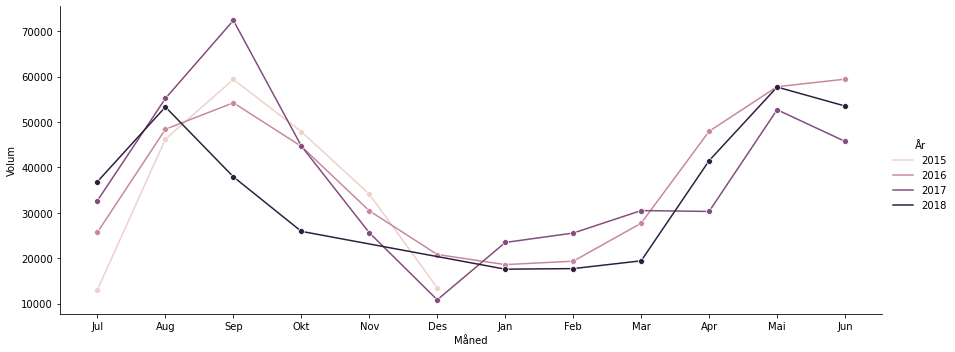

In [32]:
# months list
months = visual_train.Måned

# plotter dataen
p = sns.relplot(kind='line', data=visual_train, x='Måned', y='Volum',hue = 'År', aspect=2.5, marker='o')

Fra plottet kan en se det er minst aktivitet om om vinteren, og mer aktivitet ellers. Det er usikkert
hva de store toppene er, men kan være preget av perioder med fint vær før den gjentakende duppen som trolig er på
bakgrunn av fellesferie i juli.

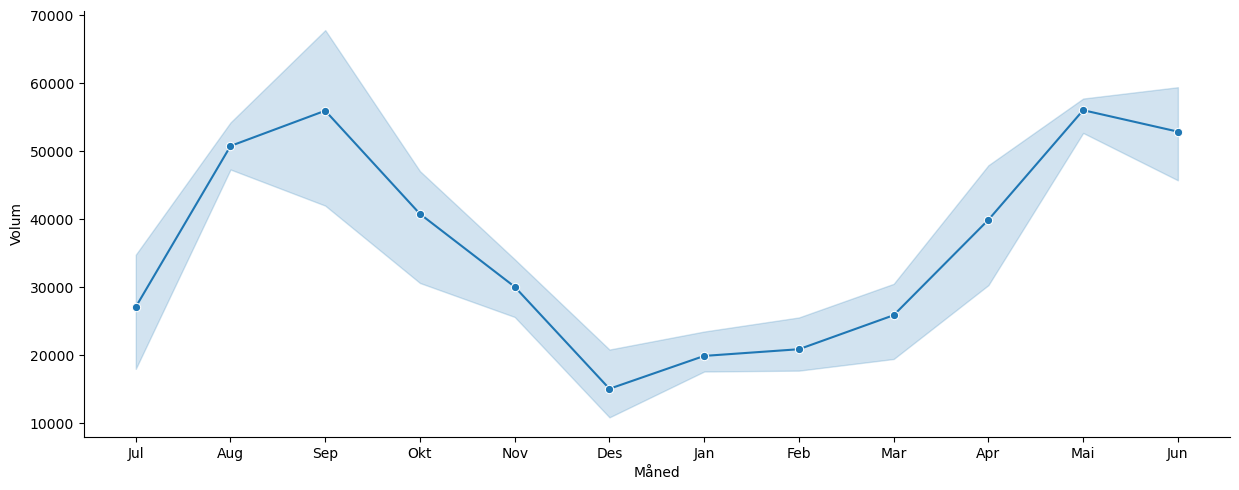

In [33]:
# denne visualiseringe viser litt klarere forskjellen på volumet per måned
p = sns.relplot(kind='line', data=visual_train, x='Måned', y='Volum', aspect=2.5, marker='o')

Videre vil jeg se om det finnes en grad av avhengighet mellom variablene i datasettet. Det kan hjelpe
i prosessen hvor en skal velge hvilke variabler en tar med videre til modelleringen senere, der ulikt valg av
variabler kan gi forskjellige resultat. 

Nedenfor bruker jeg to metoder for å finne korrelasjon; dataframe.corr() og sns.heatmap().
Korrelasjonsverdi på 0 betyr det ikke er korrelasjon, korrelasjon på 1 betyr perfekt positiv korrelasjon

In [34]:
# Pandas dataframe.corr() er brukt til å finne parvis korrelasjon av alle numeriske kolonner i datasettet.
corr_df = X_train.copy()
corr_df['Volum'] = y_train

corr = corr_df.corr()
corr

,År,Måned,Dato,Ukedag,Klokkeslett,Lufttemperatur,Vindstyrke,Lufttrykk,Fellesferie,Globalstraling,Solskinstid,Dekningsgrad (%),Volum
År,1.000000,-0.339794,-0.037364,-0.003548,-0.000827,-0.039946,0.007644,0.009473,0.024303,0.085997,0.076923,0.032498,-0.007528
Måned,-0.339794,1.000000,0.000183,0.004403,-0.000471,0.307413,-0.008513,-0.002353,0.029887,-0.082154,-0.063924,0.013282,0.051836
Dato,-0.037364,0.000183,1.000000,-0.003710,0.000082,0.045036,0.026152,-0.003675,0.045878,0.009745,0.001828,-0.019542,-0.003606
Ukedag,-0.003548,0.004403,-0.003710,1.000000,-0.000742,-0.007635,-0.010493,-0.002418,0.008338,-0.010131,-0.013064,0.015364,-0.242125
Klokkeslett,-0.000827,-0.000471,0.000082,-0.000742,1.000000,0.068506,0.047523,0.006956,0.001531,-0.005356,0.020309,0.063584,0.158018
Lufttemperatur,-0.039946,0.307413,0.045036,-0.007635,0.068506,1.000000,0.077294,0.134893,0.313046,0.372252,0.292962,0.027860,0.301113
Vindstyrke,0.007644,-0.008513,0.026152,-0.010493,0.047523,0.077294,1.000000,-0.202562,-0.057971,0.051285,-0.015669,0.006975,0.025168
Lufttrykk,0.009473,-0.002353,-0.003675,-0.002418,0.006956,0.134893,-0.202562,1.000000,0.007494,0.139998,0.195226,0.003535,0.100908
Fellesferie,0.024303,0.029887,0.045878,0.008338,0.001531,0.313046,-0.057971,0.007494,1.000000,0.139369,0.078183,0.008528,-0.043298
Globalstraling,0.085997,-0.082154,0.009745,-0.010131,-0.005356,0.372252,0.051285,0.139998,0.139369,1.000000,0.727448,0.014510,0.290734


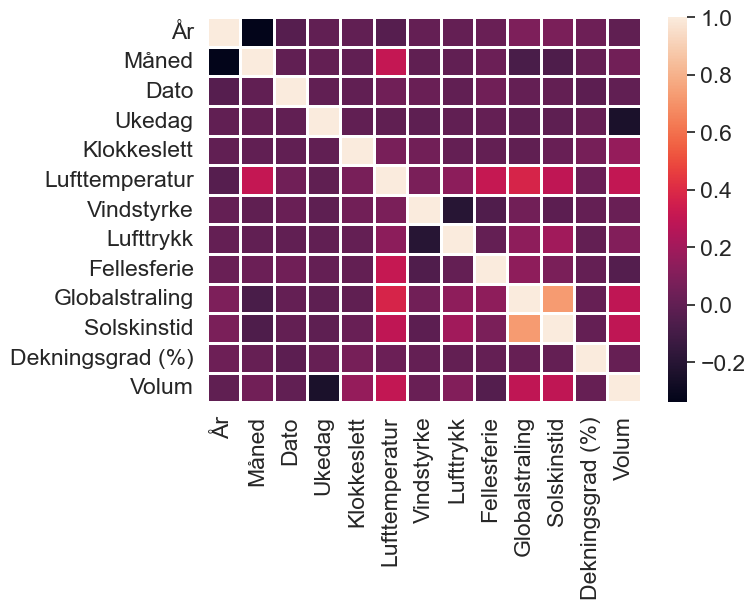

In [35]:
# Lager et heatmap
plt.figure(figsize = (7,5))
sns.set(font_scale=1.5)
corr_heatmap = sns.heatmap(corr, xticklabels=corr_df.columns, yticklabels=corr_df.columns, linewidths=1)

Ser at 'Solskinstid', 'Globalstråling' og 'Lufttemperatur' har de bedre korrelasjonene til 'Volum'.

'Dekningsgrad(%)' har ikke god korrelasjon til 'Volum'. Tar ikke med den videre. 

'Vindstyrke' har ikke god korrelasjon til 'Volum'. Tar ikke med den videre.

På grunn av den store gjentakende nedgangen i juli-perioden velger jeg å ta med 'Fellesferie' videre i modellen.

In [36]:
feature_cols = ['År','Måned', 'Dato','Ukedag', 'Klokkeslett', 'Lufttemperatur',
                'Vindstyrke','Lufttrykk', 'Fellesferie','Globalstraling', 'Solskinstid', 'Volum']

merged_df = merged_df[feature_cols].copy()

In [37]:
# Lager directory og plasserer merged_data i en mappe som videre skal bli brukt i modellering.
path = 'clean_data'

# Plasser filene
merged_df.to_csv(path+'/merged_df.csv', index = False)
target_df.to_csv(path+'/target_df.csv', index = False)